In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 8
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import tflscripts
import matplotlib.cm as cm
import matplotlib.colors as colors
configuration = tflscripts.read_configuration()

In [3]:
force_columns = None
use_columns = None

training_source_data_ratio = 0.6
training_target_data_ratio = 0.6
testing_target_data_ratio = 0.4

tflscripts.set_dataset_folder('/home/giotto/transfer-learning-playground/datasets/')

In [4]:
def rename_labels_based_on_configuration(df_labels):
    configuration = tflscripts.read_configuration()
    for i, activity in enumerate(configuration['activities']):
        df_labels['label'] = df_labels['label'].replace([i], activity)

def plot_tsne(df, df_labels, title=''):
    X = df.values
    # calculate tsne
    model = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    transformed = model.fit_transform(X)

    df = pd.DataFrame(transformed, columns=['x', 'y'])
    df['label'] = df_labels.label

    fig, ax = plt.subplots()

    labels = df.label.unique()

    colormap = cm.viridis
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(labels))]
    markers = ['^', 'o', 'v', 's', 'd']

    for i, label in enumerate(labels):
        c = colorlist[i]
        subdf = df.loc[df.label == label]
        if len(subdf):
            subdf.plot.scatter('x', 'y',
                               marker=markers[i % len(markers)], s=50,
                               label=label, ax=ax, c=c)

    plt.title(title)

    ax.legend()
    plt.savefig('plots/tsne.pdf')
    plt.show()

def compare(devices_and_datasets, use_features, use_activities, title='', sample_rate=1):
    dfs = []
    dfs_labels = []
    for i, device_dataset in enumerate(devices_and_datasets):
        device = device_dataset[0]
        dataset = device_dataset[1]
        name = device_dataset[2]

        all_activities = [configuration['activities'].index(a) for a in configuration['analysed_activities']]
        df, df_labels = tflscripts.read_and_filter_dataset(
            dataset,
            device,
            use_features=use_features,
            force_columns=force_columns,
            use_columns=use_columns,
            use_activities=all_activities,
            check_all_activities=False,
            scale=True,
            with_feature_selection=False)
        
        df_labels = df_labels.loc[df_labels.label.isin(use_activities)]
        df = df.loc[df.index.isin(df_labels.index)]

        _dfs = tflscripts.take_multiple_percentages_of_data(df, df_labels, [sample_rate])
        df, df_labels = _dfs[0]

        rename_labels_based_on_configuration(df_labels)
        if len(use_activities) > 1:
            df_labels['label'] = df_labels['label'].astype(str) + ' ' + name
        else:
            df_labels['label'] = name

        dfs.append(df)
        dfs_labels.append(df_labels)
        
    df, df_labels = tflscripts.concat_and_reindex(dfs, dfs_labels)
    plot_tsne(df, df_labels, title)

In [13]:
dataset = 'synergy-final-iter1-1s'
device = '128.237.254.195'
use_features = 'MICROPHONE|microphone'
use_activities = configuration['analysed_activities']
use_activities = [configuration['activities'].index(a) for a in use_activities]
print(use_activities)

df, df_labels = tflscripts.read_and_filter_dataset(
    dataset,
    device,
    use_features=use_features,
    force_columns=force_columns,
    use_columns=use_columns,
    use_activities=use_activities,
    check_all_activities=False,
    scale=True,
    with_feature_selection=False)

rename_labels_based_on_configuration(df_labels)
plot_tsne(df, df_labels, 'All activities within a single dataset using microphone')

[0, 3, 1, 2, 5, 7, 8, 11, 12, 13, 14, 18, 21, 22, 23, 24, 25]


KeyboardInterrupt: 

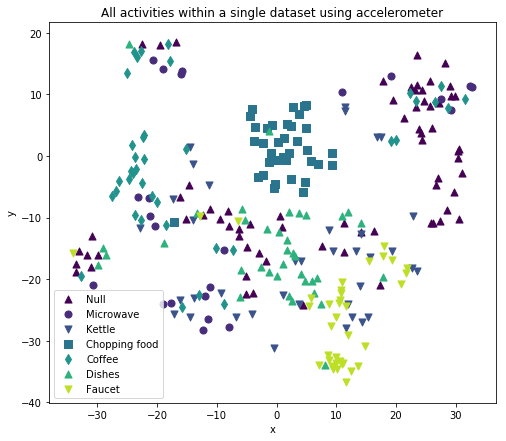

In [25]:
dataset = 'scott-final-iter1'
device = '128.237.247.134'
use_features = 'microphone'
use_activities = [0,1,2,3,4,5,7]

df, df_labels = tflscripts.read_and_filter_dataset(
    dataset,
    device,
    use_features=use_features,
    force_columns=force_columns,
    use_columns=use_columns,
    use_activities=use_activities,
    scale=True,
    with_feature_selection=False)

feature_types = [
    'variance',
    'standard_deviation',
    'ratio_value_number_to_time_series_length',
    'maximum',
    'mean_abs_change_quantiles__qh_1.0__ql_0.0',
    'absolute_sum_of_changes',
    'mean_abs_change',
    'mean_abs_change_quantiles__qh_1.0__ql_0.2',
    'mean_abs_change_quantiles__qh_1.0__ql_0.4',
    'mean_abs_change_quantiles__qh_1.0__ql_0.6',
    'mean',
    'skewness',
    'percentage_of_reoccurring_values_to_all_values',
    'kurtosis',
    'abs_energy',
    'quantile__q_0.9',
    'sum_values',
    'quantile__q_0.3',
    'mean_abs_change_quantiles__qh_1.0__ql_0.8',
    'variance_larger_than_standard_deviation'
]

df = df.filter(regex='|'.join(feature_types))

rename_labels_based_on_configuration(df_labels)
plot_tsne(df, df_labels, 'All activities within a single dataset using accelerometer')

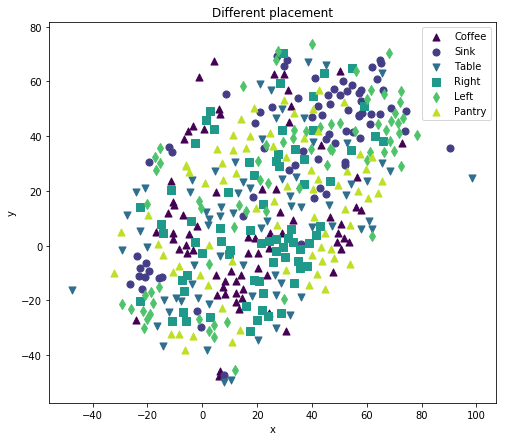

In [71]:
use_features = 'microphone|MICROPHONE'
use_activities = ['Chopping food']
use_activities = [configuration['activities'].index(a) for a in use_activities]

compare([
    ['128.237.246.127', 'synergy-final-iter1-1s', 'Coffee'],
    ['128.237.248.186', 'synergy-final-iter2-1s', 'Sink'],
    ['128.237.248.186', 'synergy-final-iter1-1s', 'Table'],
    ['128.237.247.134', 'scott-final-iter1-1s', 'Right'],
    ['128.237.248.186', 'scott-final-iter1-1s', 'Left'],
    ['128.237.246.127', 'scott-final-iter1-1s', 'Pantry']
], use_features=use_features, use_activities=use_activities, title='Different placement', sample_rate=0.2)

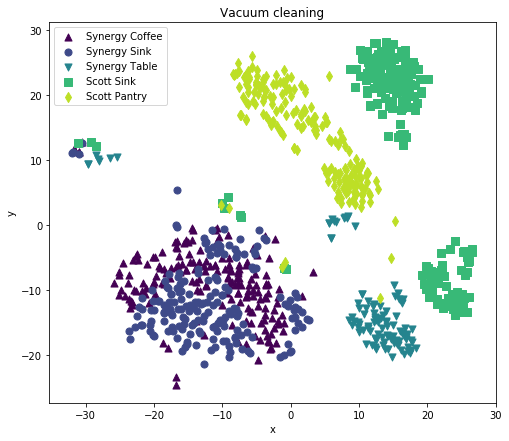

In [8]:
use_features = 'microphone|MICROPHONE'
use_activities = ['Vacuum cleaning']
use_activities = [configuration['activities'].index(a) for a in use_activities]

compare([
    ['128.237.227.76', 'synergy-final-iter4-1s', 'Synergy Coffee'],
    ['128.237.250.218', 'synergy-final-iter4-1s', 'Synergy Sink'],
    ['128.237.247.190', 'synergy-final-iter4-1s', 'Synergy Table'],
#     ['128.237.250.218', 'scott-final-iter3-1s', 'Scott Right'],
    ['128.237.227.76', 'scott-final-iter3-1s', 'Scott Sink'],
    ['128.237.247.190', 'scott-final-iter3-1s', 'Scott Pantry']
], use_features=use_features, use_activities=use_activities, title='Vacuum cleaning', sample_rate=0.5)

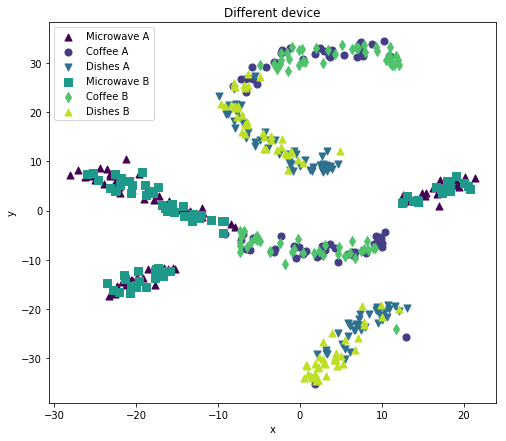

In [180]:
use_features = 'accel_.*index_mass_quantile'
use_activities = [0,1,2]

compare([
    ['xdk_1', 'synergy-final-iter1', 'A'],
    ['Matrix b827ebe6e0f8', 'synergy-final-iter2', 'B']
], use_features=use_features, use_activities=use_activities, title='Different device')

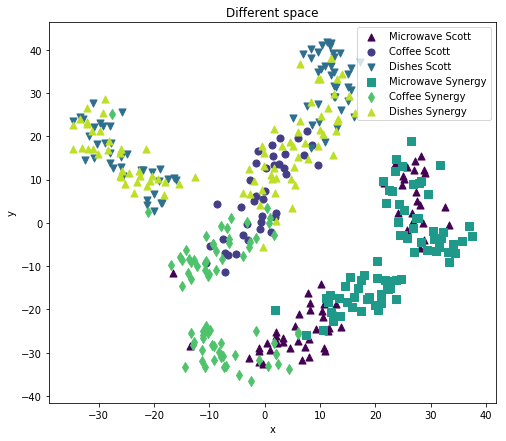

In [181]:
use_features = 'accel_.*index_mass_quantile'
use_activities = [0,1,2]

compare([
    ['xdk_1', 'scott-final-iter1', 'Scott'],
    ['xdk_1', 'synergy-final-iter1', 'Synergy']
], use_features=use_features, use_activities=use_activities, title='Different space')

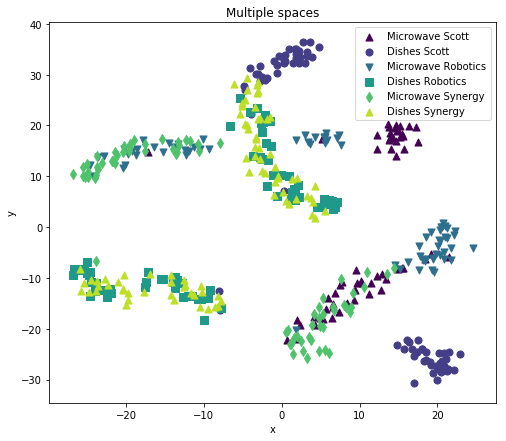

In [184]:
use_features = 'microphone.*index_mass_quantile'
use_activities = [0,1]

compare([
    ['Matrix b827ebe6e0f8', 'scott-final-iter1', 'Scott'],
    ['Matrix b827ebe6e0f8', 'robotics-final', 'Robotics'],
    ['Matrix b827ebe6e0f8', 'synergy-final-iter1', 'Synergy']
], use_features=use_features, use_activities=use_activities, title='Multiple spaces')